Find Tidal Ellipses in CODAR region and VENUS ADCP vertical profiles

In [20]:
# imports
import cmocean.cm as cm
import os
import glob
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
import numpy as np
import xarray as xr
from scipy.optimize import curve_fit
from salishsea_tools import tidetools
from salishsea_tools import viz_tools
from matplotlib.patches import Ellipse

%matplotlib inline

In [2]:
# get bathymetric and grid information
grid = xr.open_dataset('../../../grid/bathymetry_201702.nc')
grid_lats = grid["nav_lat"][:]
grid_lons = grid["nav_lon"][:]
grid_bathy = grid["Bathymetry"][:]

In [175]:
imin = 379; imax = 461; jmin = 238; jmax=321; ndays = 30

In [176]:
vvel = np.zeros((ndays*24, 40, imax-imin, jmax-jmin)); uvel =np.zeros_like(vvel)
DIRECTORY = '/results2/SalishSea/nowcast-green.201905/'
count = 0
for filename in sorted(glob.glob(os.path.join(DIRECTORY, '??apr20/SalishSea_1h*_grid_[UV].nc'))):
    fn = xr.open_dataset(filename)
    print (count, filename)
    if "grid_U" in filename:
        print(fn.vozocrtx[:, :, imin:imax, jmin:jmax].shape, uvel[count:count+24, :, :, ].shape)
        uvel[count:count+24, :, :, ] = viz_tools.unstagger_xarray(fn.vozocrtx[:, :, imin:imax, jmin:jmax], 'x')
        if count == 0:
            depths = fn.depthu[:]
    else:
        vvel[count:count+24, :, :, ] = viz_tools.unstagger_xarray(fn.vomecrty[:, :, imin:imax, jmin:jmax], 'y')
        count = count + 24
        print ('the count', count)
    fn.close()

0 /results2/SalishSea/nowcast-green.201905/01apr20/SalishSea_1h_20200401_20200401_grid_U.nc
(24, 40, 82, 83) (24, 40, 82, 83)
0 /results2/SalishSea/nowcast-green.201905/01apr20/SalishSea_1h_20200401_20200401_grid_V.nc
the count 24
24 /results2/SalishSea/nowcast-green.201905/02apr20/SalishSea_1h_20200402_20200402_grid_U.nc
(24, 40, 82, 83) (24, 40, 82, 83)
24 /results2/SalishSea/nowcast-green.201905/02apr20/SalishSea_1h_20200402_20200402_grid_V.nc
the count 48
48 /results2/SalishSea/nowcast-green.201905/03apr20/SalishSea_1h_20200403_20200403_grid_U.nc
(24, 40, 82, 83) (24, 40, 82, 83)
48 /results2/SalishSea/nowcast-green.201905/03apr20/SalishSea_1h_20200403_20200403_grid_V.nc
the count 72
72 /results2/SalishSea/nowcast-green.201905/04apr20/SalishSea_1h_20200404_20200404_grid_U.nc
(24, 40, 82, 83) (24, 40, 82, 83)
72 /results2/SalishSea/nowcast-green.201905/04apr20/SalishSea_1h_20200404_20200404_grid_V.nc
the count 96
96 /results2/SalishSea/nowcast-green.201905/05apr20/SalishSea_1h_20200

In [178]:
print (uvel.shape)

(720, 40, 82, 83)


-727.6148230381368


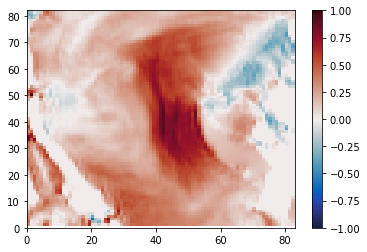

In [177]:
# Just a quick plot to check things are approximately reasonable
fig, ax = plt.subplots(1, 1)
mesh = ax.pcolormesh(vvel[28, 0], cmap=cm.balance, vmax=1, vmin=-1)
fig.colorbar(mesh)
print (uvel[ndays*24-4, 0, :, 1:].sum())

In [179]:
# Initialize the Tide Information
# frequencies
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
K1freq = 15.041069*np.pi/180.
# initialize fit
vM2amp = np.zeros(thesize); vM2pha = np.zeros(thesize)
vK1amp = np.zeros(thesize); vK1pha = np.zeros(thesize)
uM2amp = np.zeros(thesize); uM2pha = np.zeros(thesize)
uK1amp = np.zeros(thesize); uK1pha = np.zeros(thesize)
mean = np.zeros(thesize)

In [14]:
# function for fit, this assumes two tides only
def double(x, M2amp, M2pha, K1amp, K1pha, mean):
    return (mean + M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.))

In [41]:
# function to do the fitting and actually find the tidal components
def fittit (uaus, vaus, time, imin, imax, jmin, jmax, dj=1, ts=0):
    for i in np.arange(imin,imax):
        for j in np.arange(jmin,jmax,dj):
            if vaus[:,i,j].any() != 0.:
                fitted, cov = curve_fit(double, time[ts:], vaus[:,i,j]) 
                if fitted[0] < 0:
                    fitted[0] = -fitted[0]
                    fitted[1] = fitted[1]+180.
                if fitted[1] > 180:
                    fitted[1] = fitted[1] - 360.
                elif fitted[1] < -180-360:
                    fitted[1] = fitted[1] + 720.
                elif fitted [1] < -180:
                    fitted[1] = fitted[1] + 360.
                if fitted[2] < 0:
                    fitted[2] = -fitted[2]
                    fitted[3] = fitted[3]+180.
                vM2amp[i,j] = fitted[0]
                vM2pha[i,j] = fitted[1]
                vK1amp[i,j] = fitted[2]
                vK1pha[i,j] = fitted[3]
    print ('vaus done')
    for i in np.arange(imin,imax):
        for j in np.arange(jmin,jmax,dj):
            if uaus[:,i,j].any() !=0.:
                fitted, cov = curve_fit(double,time[ts:],uaus[:,i,j]) 
                if fitted[0] < 0:
                    fitted[0] = -fitted[0]
                    fitted[1] = fitted[1]+180.
                if fitted[1] > 180+360:
                    fitted[1] = fitted[1] -720
                elif fitted[1] > 180:
                    fitted[1] = fitted[1] - 360.
                elif fitted[1] < -180-360:
                    fitted[1] = fitted[1] + 720.
                elif fitted [1] < -180:
                    fitted[1] = fitted[1] + 360.
                if fitted[2] < 0:
                    fitted[2] = -fitted[2]
                    fitted[3] = fitted[3]+180.
                uM2amp[i,j] = fitted[0]
                uM2pha[i,j] = fitted[1]
                uK1amp[i,j] = fitted[2]
                uK1pha[i,j] = fitted[3]
    return vM2amp, vM2pha, vK1amp, vK1pha, uM2amp, uM2pha, uK1amp, uK1pha

Find the tidal amplitudes and phases.  Print one out to make sure its working.

In [180]:
vM2amp, vM2pha, vK1amp, vK1pha, uM2amp, uM2pha, uK1amp, uK1pha = fittit (uvel[:,1, 1:, 1:], vvel[:, 1, 1:, 1:], 
                                                                         np.arange(ndays*24), 0, imax-imin-1, 0, jmax-jmin-1)
print (uM2amp[420-imin,280-jmin],uM2pha[420-imin,280-jmin],vM2amp[420-imin,280-jmin],vM2pha[420-imin,280-jmin])

vaus done
0.047065767697252 -138.3703675320491 0.23450544153861744 126.75288346999568


Plot the amplitude and phase of the two velocities

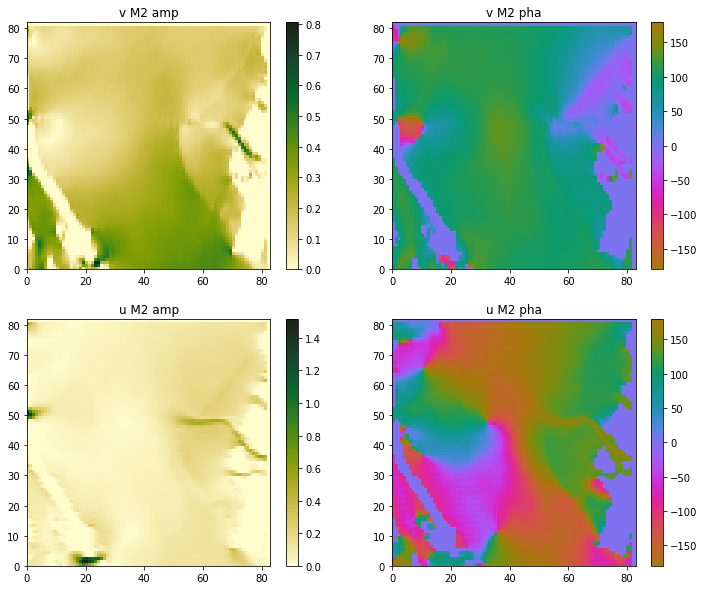

In [181]:
fig = plt.figure(figsize=(2*5.5+1,2*5))

plt.subplot(2,2,1)

plt.pcolormesh(vM2amp, cmap=cm.speed)
plt.colorbar()
plt.title('v M2 amp')

plt.subplot(2,2,2)
plt.pcolormesh(vM2pha,cmap=cm.phase)
plt.colorbar()
plt.title('v M2 pha')

plt.subplot(2,2,3)
plt.pcolormesh(uM2amp, cmap=cm.speed)
plt.colorbar()
plt.title('u M2 amp')

plt.subplot(2,2,4)
plt.pcolormesh(uM2pha,cmap=cm.phase)
plt.colorbar()
plt.title('u M2 pha');


In [51]:
# this function calculates ellipse parameters based on the amplitude and phase.  From Foreman (1977)
def ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha):
    CX = uM2amp*np.cos(np.pi*uM2pha/180.)
    SX = uM2amp*np.sin(np.pi*uM2pha/180.)
    CY = vM2amp*np.cos(np.pi*vM2pha/180.)
    SY = vM2amp*np.sin(np.pi*vM2pha/180.)
    ap = np.sqrt((CX+SY)**2+(CY-SX)**2)/2.  # amplitude of positively rotating component
    am = np.sqrt((CX-SY)**2+(CY+SX)**2)/2.  # amplitude of negatively rotating component
    ep = np.arctan2(CY-SX,CX+SY)+np.pi       # phase of positive
    em = np.arctan2(CY+SX,CX-SY)+np.pi      # phase of negative
    major = ap+am                           # major axis
    minor = ap-am                           # signed minor axis
    theta = (ep+em)/2.*180./np.pi           # axis tilt
    theta %= 180                             # by convention theta is between 0 and 180.
    return CX, SX, CY, SY, ap, am, ep, em, major, minor, theta

Calculate ellipse parameters and plot angles of them.

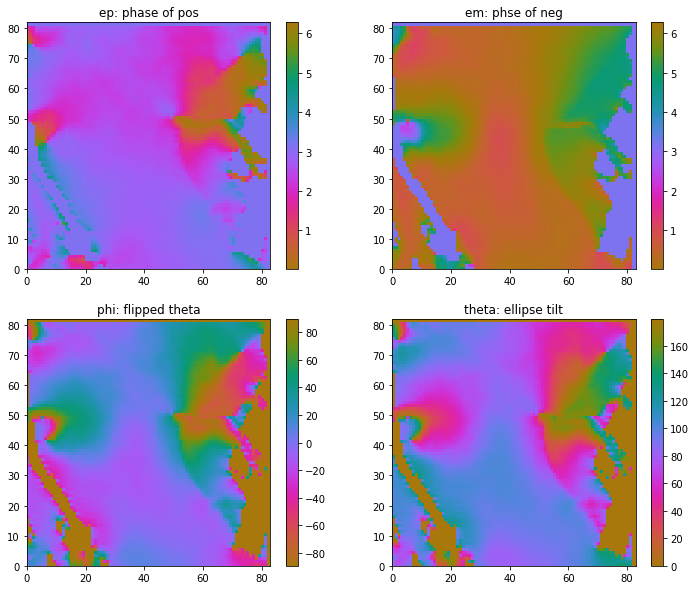

In [182]:
CX, SX, CY, SY, ap, am, ep, em, major, minor, theta = ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)
fig=plt.figure(figsize=(2*5.5+1,2*5))
plt.subplot(221)
plt.pcolormesh(ep, cmap=cm.phase)
plt.colorbar()
plt.title('ep: phase of pos')

plt.subplot(222)
plt.pcolormesh(em, cmap=cm.phase)
plt.colorbar()
plt.title('em: phse of neg')

plt.subplot(223)
plt.pcolormesh(90-theta,cmap=cm.phase)
plt.colorbar()
plt.title('phi: flipped theta')

plt.subplot(224)
plt.pcolormesh(theta, cmap=cm.phase)
plt.colorbar()
plt.title('theta: ellipse tilt');



## Use grid rotated grid coordinates, So Ellipses keep shape

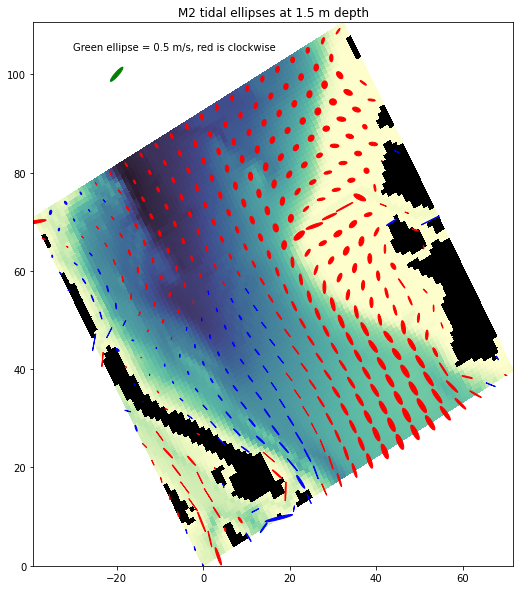

In [207]:
# rotate grid, then label axes in lats/longs

phi = 29. # the twist in the grid
k = np.zeros_like(vM2amp); m = np.zeros_like(vM2amp)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
for i in np.arange(imax-imin):
    for j in np.arange(jmax-jmin):
        k[i,j] = i*np.cos(phi*np.pi/180.) + j*np.sin(phi*np.pi/180.)
        m[i,j] = -i*np.sin(phi*np.pi/180.) + j*np.cos(phi*np.pi/180.) 
scale = 8.
interval = 4
for i in np.arange(0,imax-imin,interval):
    for j in np.arange(0,jmax-jmin,interval):
        if ap[i,j] > am[i,j]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(m[i,j],k[i,j]), width=scale*major[i,j], 
                            height=scale*minor[i,j], angle=theta[i,j]+29.,
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)


# scale ellipse
ell = Ellipse(xy=(-20, 100),width = scale*0.5, height = scale*0.1, angle = 45,
              color='g')
ax.add_artist(ell)

# land, and 5 m contour
cmap_depth = plt.get_cmap(cm.deep)
cmap_depth.set_bad('black')
ax.pcolormesh(m[0:imax-imin, 0:jmax-jmin], k[0:imax-imin, 0:jmax-jmin],
            grid_bathy[imin:imax,jmin:jmax], cmap=cmap_depth)

ax.set_title("M2 tidal ellipses at 1.5 m depth")

ax.text(-30, 105, "Green ellipse = 0.5 m/s, red is clockwise");

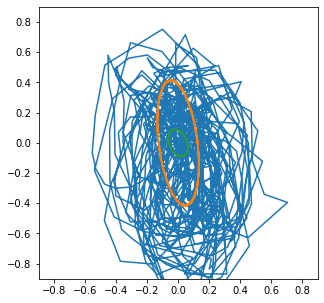

In [200]:
CXK, SXK, CYK, SYK, dap, dam, dep, dem, dmajor, dminor, dtheta = ellipse_params(uK1amp, uK1pha, vK1amp, vK1pha)
j=384-imin; i=298-jmin
plt.figure(figsize=(5,5))
plt.xlim(-0.9,0.9)
plt.ylim(-0.9,0.9)
plt.plot(uvel[:, 1, j, i],vvel[:, 1, j, i])
plt.plot(CX[j,i]*np.cos(M2freq*x)+SX[j,i]*np.sin(M2freq*x),
         CY[j,i]*np.cos(M2freq*x)+SY[j,i]*np.sin(M2freq*x));
plt.plot(CXK[j,i]*np.cos(K1freq*x)+SXK[j,i]*np.sin(K1freq*x),
         CYK[j,i]*np.cos(K1freq*x)+SYK[j,i]*np.sin(K1freq*x));

81.33127590991245


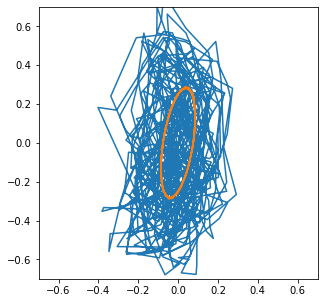

In [185]:
j=415-imin; i=285-jmin

plt.figure(figsize=(5,5))
plt.plot(uvel[:, 1, j, i],vvel[:, 1, j, i])
plt.xlim(-0.7,0.7)
plt.ylim(-0.7,0.7)
plt.plot(CX[j,i]*np.cos(M2freq*x)+SX[j,i]*np.sin(M2freq*x),
         CY[j,i]*np.cos(M2freq*x)+SY[j,i]*np.sin(M2freq*x))
print (theta[j,i])

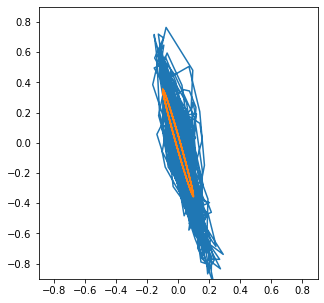

In [197]:
j=400-imin;i=244-jmin
plt.figure(figsize=(5,5))
plt.plot(uvel[:, 1,j,i],vvel[:, 1,j,i])
plt.xlim(-0.9,0.9)
plt.ylim(-0.9,0.9)

plt.plot(CX[j,i]*np.cos(M2freq*x)+SX[j,i]*np.sin(M2freq*x),
         CY[j,i]*np.cos(M2freq*x)+SY[j,i]*np.sin(M2freq*x));

#### Now look at ACDP Stations

In [201]:
ival = 424 - imin
jdeep = 267 - jmin
jsha = 282- jmin;

In [202]:
ts = 0
length = vvel.shape[0]-ts
dr = vvel.shape[1]
uaus = np.zeros((length,dr,2))
vaus = np.zeros((length,dr,2))
print (vaus.shape)

uaus = 0.5*(uvel[ts:,:,ival,(jdeep+1,jsha+1)]+uvel[ts:,:,ival,(jdeep,jsha)])
vaus = 0.5*(vvel[ts:,:,ival+1,(jdeep,jsha)]+vvel[ts:,:,ival,(jdeep,jsha)])

(720, 40, 2)


In [203]:
vM2amp, vM2pha, vK1amp, vK1pha, uM2amp, uM2pha, uK1amp, uK1pha = fittit (uaus, vaus, 
                                                                         np.arange(ndays*24), 0, dr, 
                                                                         0, 2)
CX, SX, CY, SY, ap, am, ep, em, major, minor, theta = ellipse_params (uM2amp, uM2pha, vM2amp, vM2pha)

vaus done


Green ellipse = 0.5 m/s, red is clockwise


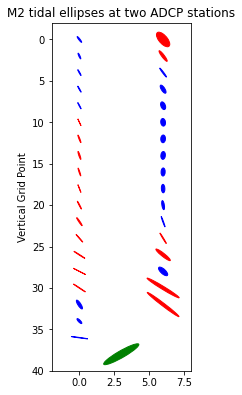

In [204]:
# correct theta (harder)
# in j,i space theta = angle up from j toward i
# in i,j space phi = angle up from i toward j
# but theta is angle from j toward i
fig = plt.figure(figsize=(5.5,6.4))
ax = fig.add_subplot(121)
scale = 7
interval = 2
for j in (0,1):
    for i in np.arange(0,dr,interval):
        if ap[i,j] > am[i,j]:
            thec = 'b'
        else:
            thec = 'r'
        ells = Ellipse(xy=(6*j,i), width=scale*major[i,j], 
                            height=scale*minor[i,j], angle=-theta[i,j]-29,
                            color=thec)
        ax.add_artist(ells)
        ells.set_facecolor(thec)
ax.set_ylim(-2,40)
ax.invert_yaxis()
ax.set_xlim(-2,8)
ell = Ellipse(xy=(3,38),width = scale*0.5, height = scale*0.1, angle =-45,
              color='g')
ax.add_artist(ell)
ax.set_title("M2 tidal ellipses at two ADCP stations")
ax.set_ylabel("Vertical Grid Point")
print ("Green ellipse = 0.5 m/s, red is clockwise")

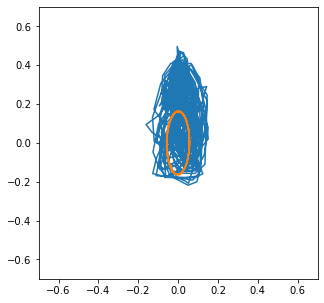

In [205]:
j=7*4;i=1
plt.figure(figsize=(5,5))
plt.plot(uaus[:,j,i],vaus[:,j,i])
plt.xlim(-0.7,0.7)
plt.ylim(-0.7,0.7)

plt.plot(CX[j,i]*np.cos(M2freq*x)+SX[j,i]*np.sin(M2freq*x),
         CY[j,i]*np.cos(M2freq*x)+SY[j,i]*np.sin(M2freq*x));